In [1]:
# prepare the data

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from src.data_preprocessing import check_data


In [2]:

qb_data = pd.read_csv('data/qb_data.csv')

target = qb_data['dk_fp']

features = qb_data.drop(columns=['player_id', 'player_display_name', 'week', 'dk_fp'])
features_shifted = features.shift(1)
# features_shifted = features.copy()

# combine shifted features with original data
features_shifted['dk_fp'] = target.copy()
features_shifted['season'] = qb_data['season']
features_shifted['player_id'] = qb_data['player_id']
features_shifted['player_display_name'] = qb_data['player_display_name']
features_shifted['week'] = qb_data['week']

features_shifted = features_shifted[features_shifted['season'] != 2018]
check_data(features_shifted, "After dropping 2018 data")

target = features_shifted['dk_fp']
features = features_shifted.drop(columns=['dk_fp'])
check_data(features, "Before dropna")

features.dropna(inplace=True)
target = target.loc[features.index]
check_data(features, "After preparing QB data for training")

# encode player_id
le = LabelEncoder()
features['player_id'] = le.fit_transform(features['player_id'])

# save player_display_name, week, and season for later
player_display_name = features['player_display_name']
week = features['week']
seasons = features['season']

features.drop(columns=['player_display_name', 'week', 'season', 'player_id'], inplace=True)


After dropping 2018 data
Shape: (2566, 44)
Missing Values:
season                                  0
defense_vs_pos                          0
implied_total_diff                      0
implied_team_total                      0
dk_fp_avg                              33
dk_fp_last1                             0
dk_fp_last3                            33
dk_fp_last5                            33
is_rookie                               0
completions                             0
attempts                                0
passing_yards                           0
passing_tds                             0
interceptions                           0
sacks                                   0
sack_yards                              0
passing_air_yards                       0
passing_yards_after_catch               0
passing_epa                             0
pacr                                    0
dakota                                  0
passing_first_downs                     0
carries          

In [3]:
tscv = TimeSeriesSplit(n_splits=5)
scaler = StandardScaler()


models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42)
]


In [4]:

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid_rf, cv=tscv, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_rf.fit(scaler.fit_transform(features), target)

best_rf = grid_search_rf.best_estimator_

grid_search_gb = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid_gb, cv=tscv, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_gb.fit(scaler.fit_transform(features), target)

best_gb = grid_search_gb.best_estimator_

models.append(best_rf)
models.append(best_gb)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


c:\Users\BOOSE\footbalf\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
810 fits failed out of a total of 2430.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
687 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\BOOSE\footbalf\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\BOOSE\footbalf\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\BOOSE\footbalf\.venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\BOOSE\foot

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


c:\Users\BOOSE\footbalf\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3645 fits failed out of a total of 10935.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3323 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\BOOSE\footbalf\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\BOOSE\footbalf\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\BOOSE\footbalf\.venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\BOOSE\f

In [6]:

# initialize results dictionaries
final_mae = {}
final_mse = {}
final_rmse = {}
final_r2 = {}

final_results = {}

# Cross validation
for model in models:
    predictions = []
    residuals = []
    y_tests = []
    player_names = []
    weeks = []
    season_vals = []
    
    maes = []
    mses = []
    rmses = []
    r2s = []
    print(f"Evaluating {model.__class__.__name__}...")

    for train_index, test_index in tscv.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        # standardize the data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # fit the model and predict
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # store predictions and residuals
        predictions.extend(y_pred)
        residuals.extend(y_test - y_pred)
        y_tests.extend(y_test)
        player_names.extend(player_display_name.iloc[test_index])
        weeks.extend(week.iloc[test_index])
        season_vals.extend(seasons.iloc[test_index])
        
        # calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        maes.append(mae)
        mses.append(mse)
        rmses.append(rmse)
        r2s.append(r2)
        print (f"   Fold MAE: {mae:4f}, MSE: {mse:4f}, RMSE: {rmse:4f}, R2: {r2:4f}")

    # store the average metrics
    final_mae[model.__class__.__name__] = np.mean(maes)
    final_mse[model.__class__.__name__] = np.mean(mses)
    final_rmse[model.__class__.__name__] = np.mean(rmses)
    final_r2[model.__class__.__name__] = np.mean(r2s)
    final_results[model.__class__.__name__] = pd.DataFrame({
        'actual': y_tests,
        'predicted': predictions,
        'residual': residuals,
        'abs_residuals': np.abs(residuals),
        'player_display_name': player_names,
        'week': weeks,
        'season': season_vals
    })

    # print final average metrics
    print(f"{model.__class__.__name__} - Average MAE: {final_mae[model.__class__.__name__]:.4f}, Average MSE: {final_mse[model.__class__.__name__]:.4f}, Average RMSE: {final_rmse[model.__class__.__name__]:.4f} Average R2: {final_r2[model.__class__.__name__]:.4f}")

print("\nFinal Results:")
for model_name in final_mae.keys():
    print(f"{model_name} - Average MAE: {final_mae[model_name]:.4f}, Average MSE: {final_mse[model_name]:.4f}, Average RMSE: {final_rmse[model_name]:4f}, Average R2: {final_r2[model_name]:.4f}")

Evaluating LinearRegression...
   Fold MAE: 7.551854, MSE: 88.223659, RMSE: 9.392745, R2: -0.171676
   Fold MAE: 6.940629, MSE: 72.415978, RMSE: 8.509758, R2: 0.015625
   Fold MAE: 6.537809, MSE: 67.419311, RMSE: 8.210926, R2: 0.022511
   Fold MAE: 6.267516, MSE: 64.941906, RMSE: 8.058654, R2: 0.139878
   Fold MAE: 6.512636, MSE: 64.450922, RMSE: 8.028133, R2: 0.104050
LinearRegression - Average MAE: 6.7621, Average MSE: 71.4904, Average RMSE: 8.4400 Average R2: 0.0221
Evaluating Ridge...
   Fold MAE: 7.455782, MSE: 86.153990, RMSE: 9.281917, R2: -0.144189
   Fold MAE: 6.924949, MSE: 72.168037, RMSE: 8.495177, R2: 0.018995
   Fold MAE: 6.533720, MSE: 67.358449, RMSE: 8.207219, R2: 0.023394
   Fold MAE: 6.267009, MSE: 64.917167, RMSE: 8.057119, R2: 0.140206
   Fold MAE: 6.512699, MSE: 64.449363, RMSE: 8.028036, R2: 0.104071
Ridge - Average MAE: 6.7388, Average MSE: 71.0094, Average RMSE: 8.4139 Average R2: 0.0285
Evaluating Lasso...
   Fold MAE: 6.907408, MSE: 73.369626, RMSE: 8.565607,

In [7]:
gboost_results = final_results['GradientBoostingRegressor']
gboost_results_sorted = gboost_results.sort_values(by='abs_residuals', ascending=False)
gboost_results_sorted.describe()

,actual,predicted,residual,abs_residuals,week,season
count,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000
mean,17.742152,18.230995,-0.488844,6.666310,8.955450,2021.453081
std,8.573753,1.784246,8.265873,4.909479,4.926189,1.171589
min,-1.740000,14.183050,-19.605394,0.013232,1.000000,2019.000000
25%,11.525000,16.877996,-6.419508,2.791546,5.000000,2020.000000
50%,16.950000,18.169413,-1.236630,5.719184,9.000000,2021.000000
75%,23.280000,19.444684,4.926871,9.625740,13.000000,2022.000000
max,48.620000,25.233900,30.803784,30.803784,17.000000,2023.000000


In [8]:
big_misses = gboost_results_sorted[gboost_results_sorted['abs_residuals'] > 15]
big_misses_count = big_misses.groupby('player_display_name').size().sort_values(ascending=False)
big_misses_count.head(10)

player_display_name
Josh Allen         12
Patrick Mahomes     9
Lamar Jackson       8
Daniel Jones        7
Joe Burrow          6
Jalen Hurts         5
Kyler Murray        5
Tom Brady           5
Justin Fields       4
Justin Herbert      4
dtype: int64

In [9]:
gboost_results_sorted = gboost_results_sorted.loc[gboost_results_sorted['season'] == 2023]

# Step 1: Calculate Predicted Rankings
gboost_results_sorted['predicted_rank'] = gboost_results_sorted.groupby(['week'])['predicted'].rank(ascending=False)

# Step 2: Calculate Actual Rankings
gboost_results_sorted['actual_rank'] = gboost_results_sorted.groupby(['week'])['actual'].rank(ascending=False)

# Step 3: Compare Rankings - Calculate the difference between predicted and actual rankings
gboost_results_sorted['rank_difference'] = gboost_results_sorted['predicted_rank'] - gboost_results_sorted['actual_rank']
gboost_results_sorted[['predicted_rank', 'actual_rank', 'rank_difference']].describe()

,predicted_rank,actual_rank,rank_difference
count,523.000000,523.000000,523.000000
mean,16.017208,16.017208,0.000000
std,9.114727,9.114412,10.705926
min,1.000000,1.000000,-31.000000
25%,8.000000,8.000000,-7.750000
50%,16.000000,16.000000,0.000000
75%,24.000000,23.750000,7.000000
max,37.000000,37.000000,27.000000


In [13]:
gboost_results_sorted[['player_display_name', 'season', 'week', 'predicted_rank', 'actual_rank', 'rank_difference']].head(10)

,player_display_name,season,week,predicted_rank,actual_rank,rank_difference
2101,C.J. Stroud,2023,9,11.0,1.0,10.0
1823,Josh Allen,2023,12,7.0,1.0,6.0
1702,Dak Prescott,2023,10,4.0,1.0,3.0
1795,Lamar Jackson,2023,17,3.0,1.0,2.0
1853,Gardner Minshew,2023,7,22.0,3.0,19.0
1997,Sam Howell,2023,8,22.0,1.0,21.0
1931,Joe Burrow,2023,1,2.0,32.0,-30.0
1815,Josh Allen,2023,4,2.0,1.0,1.0
1750,Patrick Mahomes,2023,7,4.0,2.0,2.0
1866,Daniel Jones,2023,2,17.0,1.0,16.0


In [10]:
lamar = qb_data[qb_data['player_display_name'] == 'Lamar Jackson']
lamar.head()

,player_id,player_display_name,week,season,defense_vs_pos,implied_total_diff,implied_team_total,dk_fp,dk_fp_avg,dk_fp_last1,...,passing_tds_per_int,passing_air_yards_per_attempt,passing_air_yards_per_attempt_last5,passing_epa_per_attempt,passing_epa_per_attempt_last5,completion_pct,td_pct,td_pct_last5,rushing_epa_per_carry,rushing_tds_per_carry
453,00-0034796,Lamar Jackson,11,2018,26.454000,1.55,25.25,19.90,3.04,1.48,...,0.0,8.368421,7.945277,-0.240089,0.069722,0.684211,0.000000,0.048023,-0.048349,0.000000
454,00-0034796,Lamar Jackson,12,2018,20.101818,2.86,27.50,22.22,4.73,19.90,...,0.5,8.000000,7.945366,-0.010555,0.069590,0.560000,0.040000,0.048009,-0.066743,0.090909
455,00-0034796,Lamar Jackson,13,2018,24.545000,-2.75,22.00,17.50,6.32,22.22,...,0.0,9.095238,7.946948,-0.624058,0.068636,0.571429,0.000000,0.047943,-0.012110,0.058824
456,00-0034796,Lamar Jackson,14,2018,23.252308,-3.44,21.25,19.58,7.25,17.50,...,0.0,11.458333,7.952459,0.277439,0.068964,0.541667,0.083333,0.047999,-0.023161,0.000000
457,00-0034796,Lamar Jackson,15,2018,22.697143,2.14,26.50,17.74,8.20,19.58,...,0.0,5.956522,7.949461,-0.000714,0.068859,0.608696,0.043478,0.047992,-0.199768,0.000000


In [14]:
def plot_residuals_distribution(residuals_df):
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals_df['residual'], bins=30, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution')
    plt.show()

def plot_actual_vs_predicted(residuals_df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='actual', y='predicted', data=residuals_df)
    plt.plot([residuals_df['actual'].min(), residuals_df['actual'].max()], 
             [residuals_df['actual'].min(), residuals_df['actual'].max()], 
             'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted')
    plt.show()

Model: LinearRegression


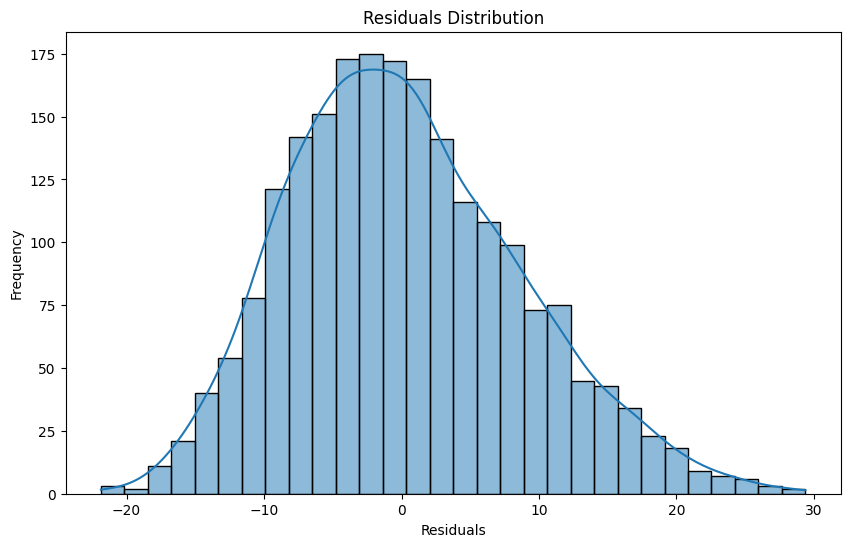

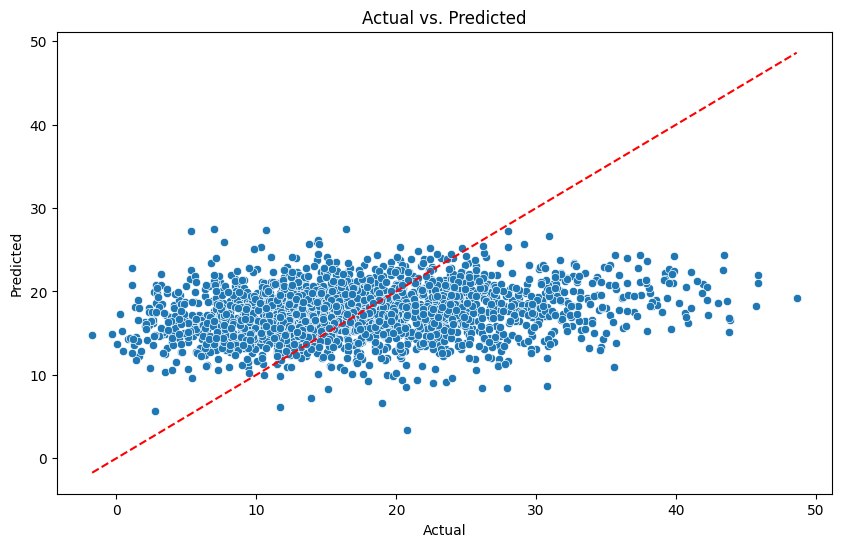

Model: Ridge


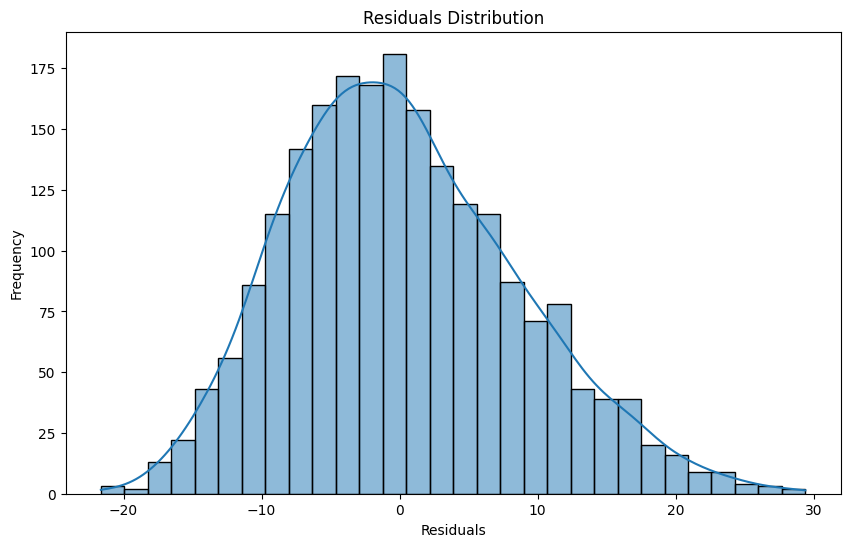

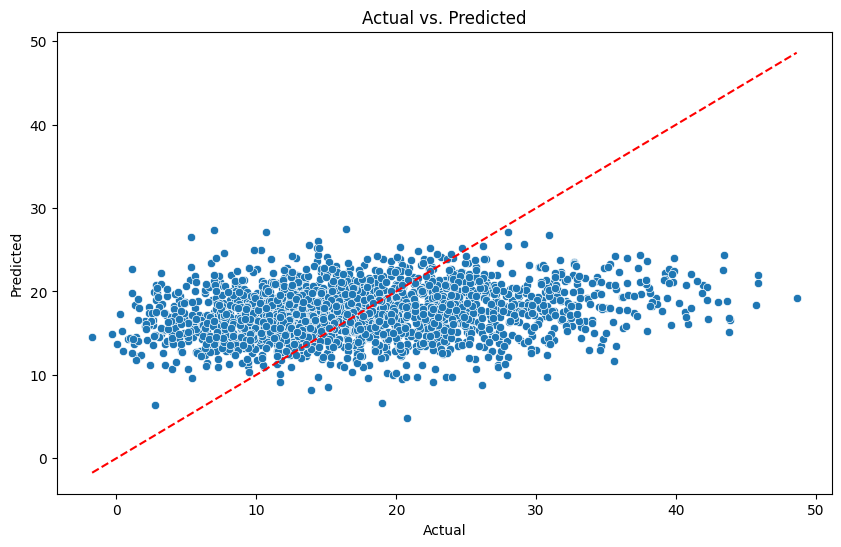

Model: Lasso


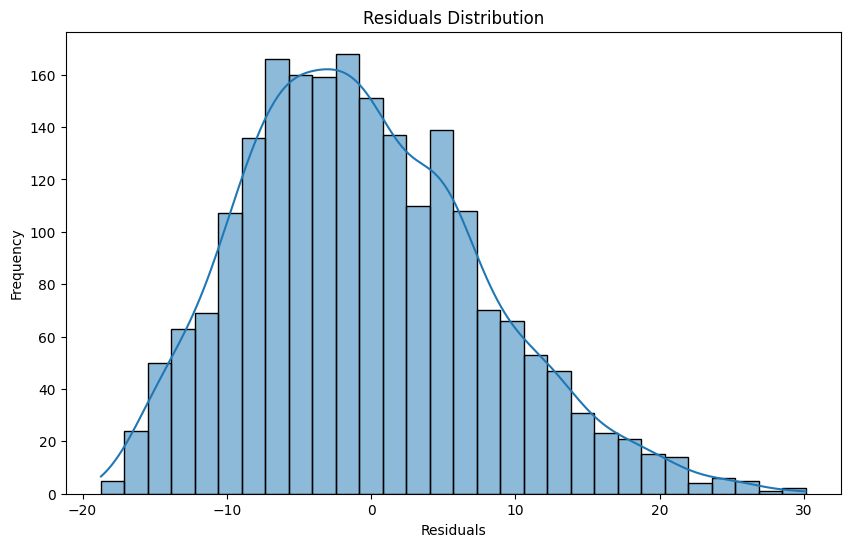

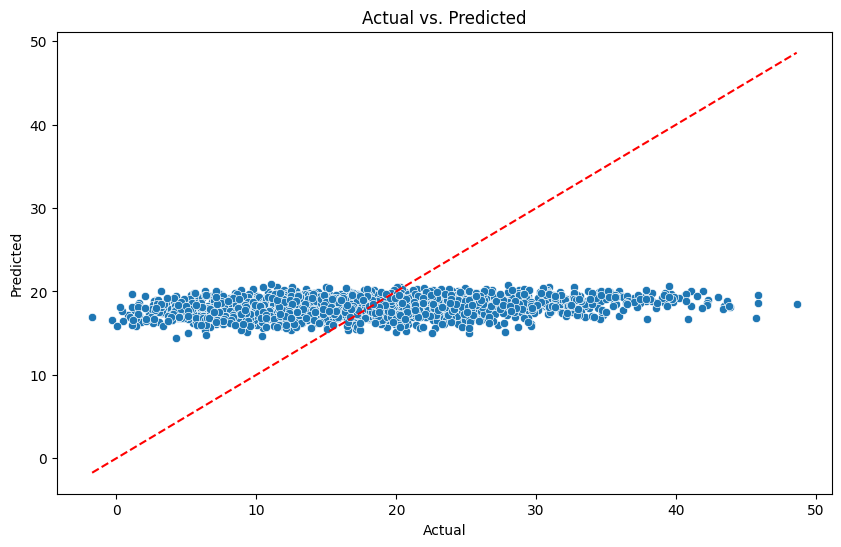

Model: DecisionTreeRegressor


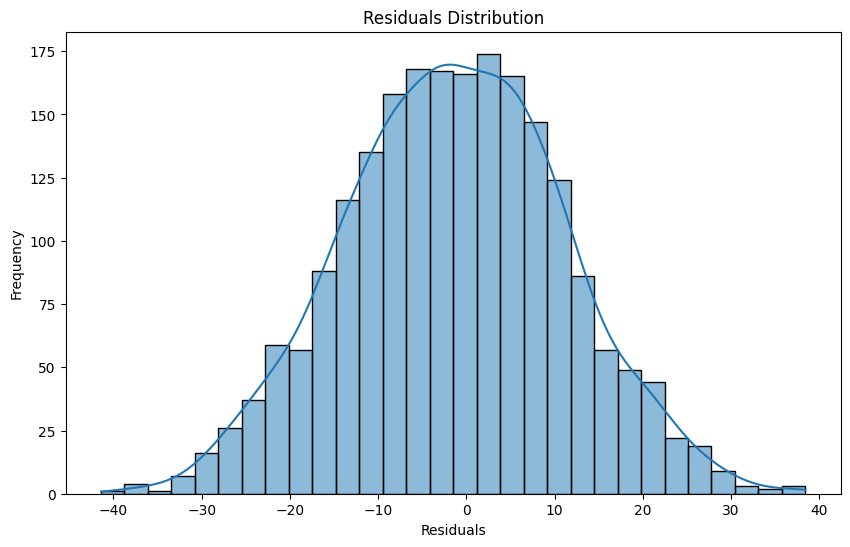

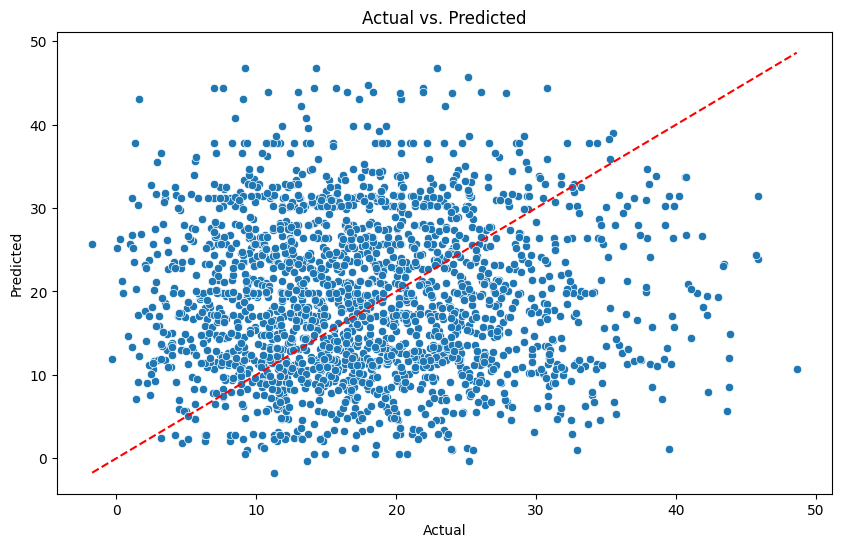

Model: RandomForestRegressor


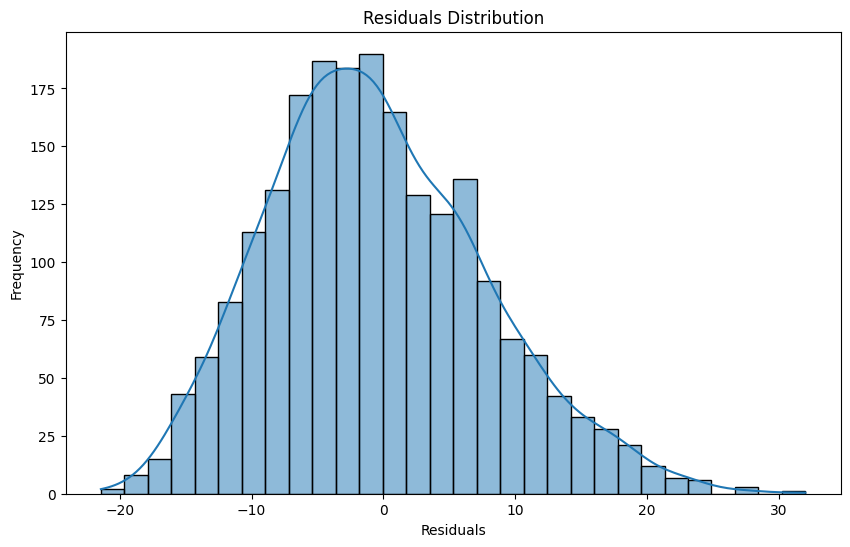

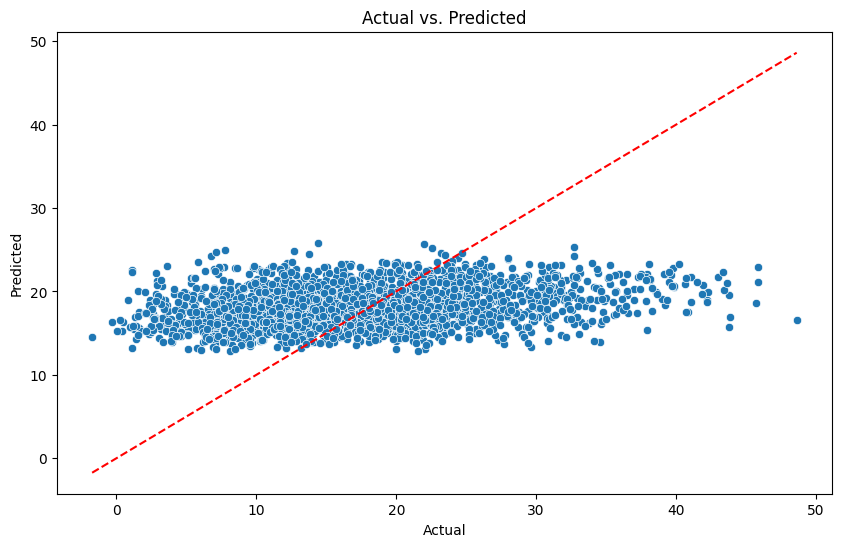

Model: GradientBoostingRegressor


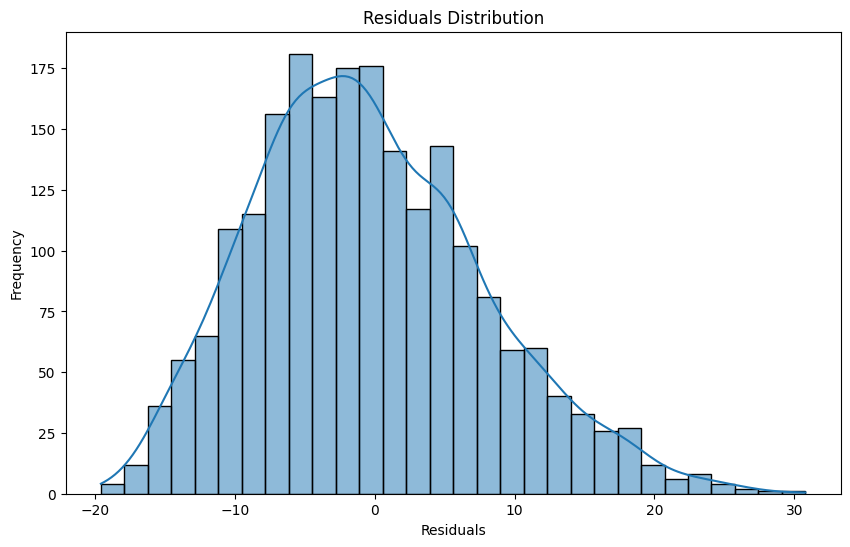

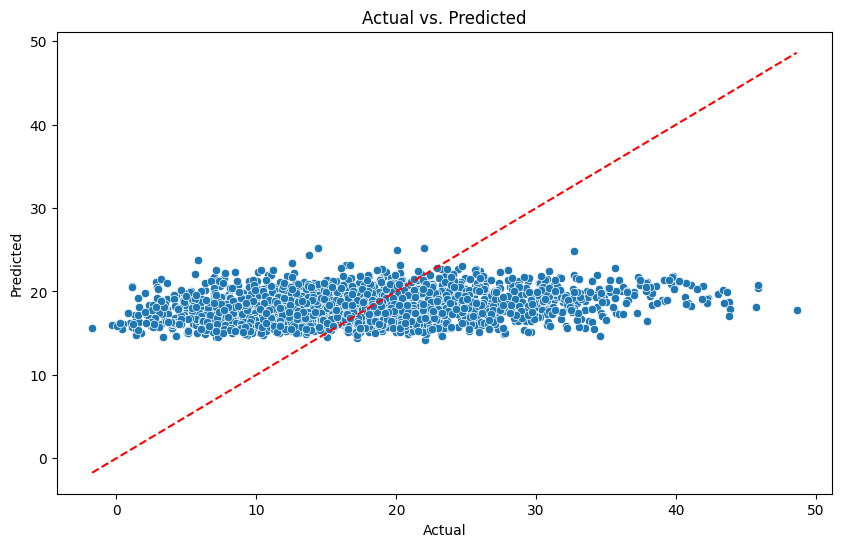

In [15]:
for model_name in final_mae.keys():
    print(f"Model: {model_name}")
    residuals_df = final_results[model_name]
    plot_residuals_distribution(residuals_df)
    plot_actual_vs_predicted(residuals_df)